In [7]:
import numpy as np 
import matplotlib.pyplot as plt
import time

import json
import random

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Custom model


### Initiate


## 업비트 데이터 10000개 가져오기



In [8]:
# 업비트 학습 데이터 가져오기

import csv
import requests

def get_upbit_candle_data():
    url = "https://crix-api-endpoint.upbit.com/v1/crix/candles/minutes/1"
    code = "CRIX.UPBIT.KRW-BTC"
    count = 400  # 한 번에 가져올 데이터 개수
    total_count = 10000  # 가져올 총 데이터 개수
    data = []  # 시세 데이터를 저장할 리스트
    
    while total_count > 0:
        params = {
            "code": code,
            "count": count
        }
        
        # 이전 데이터의 마지막 시각을 기준으로 가져옴
        if data:
            last_timestamp = data[-1]['candleDateTime']
            params['to'] = last_timestamp
        
        response = requests.get(url, params=params)
        
        if response.status_code == 200:
            candles = response.json()
            data.extend(candles)
            total_count -= len(candles)
        else:
            print("데이터를 가져오는데 실패하였습니다.")
            break
    
    return data[:10000]  # 최대 10000개의 데이터 반환

def save_to_csv(data, filename):
    keys = data[0].keys()
    
    with open(filename, 'w', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=keys)
        writer.writeheader()
        writer.writerows(data)

# 데이터 요청 및 저장
candle_data = get_upbit_candle_data()  # get_upbit_candle_data 함수를 이용해 데이터 가져오기

if candle_data:
    save_to_csv(candle_data, 'upbit_candle_data.csv')
    print("데이터를 성공적으로 저장했습니다.")

# 데이터 요청 및 출력
print(len(candle_data))


데이터를 성공적으로 저장했습니다.
10000


In [10]:
# 업비트 학습용 데이터
# 2023년 5월 13일 17시 21분 - 5월 14일 00시 00분 까지의 데이터입니다.
# /content/drive/MyDrive/Colab Notebooks/data/upbit_train_data.json

'''
with open('/content/drive/MyDrive/Colab Notebooks/data/upbit_train_data.json') as file:
    train_data = json.load(file)
    train_data = train_data[::-1]
'''
train_data = candle_data

'''
state : 이전 시세 변화량, 거래량  
state_space : 6

action : 중립, 매수, 매도 
action_space : 3

reward : 매도 시 차익을 리워드로 반환, 잃을 경우 리워드 없음. ( 매수 10, 중립은 5 리워드 )

ex)
  trade_price = 38755000
  next_trade_prive = 38697000

done : 학습 동안 reward를 5만원 이상 벌 경우, 미션에 성공했다고 판단
'''

# Q 테이블 생성
# bins = [이전 시세 증감, 거래량]
def Qtable(state_space,action_space,bin_size = 24):
    
    bins = [np.linspace(-4,4,bin_size),
            np.linspace(-4,4,bin_size),
            np.linspace(-4,4,bin_size),
            np.linspace(-4,4,bin_size),
            np.linspace(-4,4,bin_size),
            np.linspace(-4,4,bin_size)]
    
    q_table = np.random.uniform(low=-1,high=1,size=([bin_size] * state_space + [action_space]))
    return q_table, bins

# 이산화 함수
# Q 테이블이 지나치게 방대해 지는 것을 막기 위해 단순화 작업이 반드시 필요합니다.
def Discrete(state, bins):
    index = []
    for i in range(len(state)): index.append(np.digitize(state[i],bins[i]) - 1)
    return tuple(index)

# 이산화 작업 예
# print(Discrete((-58000, 4.11099952), bins))

### Q Learning function


In [11]:
def Q_learning(q_table, bins, episodes = 5000, gamma = 0.95, lr = 0.1, timestep = 5000, epsilon = 0.2):
    rewards = 0
    data = {'score' : [0]}
    start = time.time()
    ep = [i for i in range(0,episodes + 1)] 
    
    first_data = []

    # 에피소드 갯수만큼 학습을 반복
    for episode in range(1,episodes+1):

        score = 0

        # 0 : 중립, 1 : 매수, 2 : 매도
        last_diff_action = 0
        last_buy_stock = {}
        done = False # 미사용

        # 초기 값 설정
        current_stock = train_data[4]
        next_stock = train_data[5]
        current_state = Discrete([train_data[1]['tradePrice'] - train_data[0]['tradePrice'],
                                  train_data[2]['tradePrice'] - train_data[1]['tradePrice'],
                                  train_data[3]['tradePrice'] - train_data[2]['tradePrice'],
                                  train_data[4]['tradePrice'] - train_data[3]['tradePrice'],
                                  next_stock['tradePrice'] - current_stock['tradePrice'],
                                  next_stock['candleAccTradeVolume']]
                                 ,bins)
        
        # 학습 데이터를 처음부터 끝까지 학습
        for index, next_stock in enumerate(train_data):
          
          if index < 5:
            continue

          if not done:
              # 액션 선택
              # 엡실론-그리디 정책에 따라, 어느 정도 확률로 무작위 액션을 시행
              if np.random.uniform(0,1) < epsilon:
                  # 매수한 상태 (중립 0, 매도 2만 가능)
                  if last_diff_action == 1:
                    action = random.choice([0, 2])
                  # 매도한 상태 (중립 0, 매수 1만 가능)
                  elif last_diff_action == 2:
                    action = random.choice([0, 1])
                  # 매수 매도 기록 없는 경우 (중립 0, 매수 1 가능)
                  else:
                    action = random.choice([0, 1])             
              else:
                  # 또는 최적의 Q-value에 따른 액션을 선택
                  action = np.argmax(q_table[current_state])

                  # 만약 추가 매매가 최적의 액션일 경우 액션을 중립으로 변경
                  if last_diff_action == 1 and last_diff_action == action:
                    action = 0
                  elif last_diff_action == 2 and last_diff_action == action:
                    action = 0
                  elif last_diff_action == 0 and action == 2:
                    action = 0
              
              # 현재 인덱스에 해당하는 주가 데이터를 보고 해당 선택에 대한 리워드를 지급

              # 매수 행동
              if action == 1:
                reward = 10
                last_diff_action = 1
                last_buy_stock = next_stock
              # 매도 행동 (차익)
              elif action == 2:
                last_diff_action = 2
                reward = next_stock['tradePrice'] - last_buy_stock['tradePrice']
                last_buy_stock = {}
              # 중립 행동
              else:
                reward = 5

              # 마지막 학습일 경우 따로 저장
              if episode == 1 and action != 0:
                first_data_tmp = {'action' : action, 'price' : current_stock['tradePrice'], 'time' : current_stock['candleDateTime']}
                first_data.append(first_data_tmp)

              # 상태 설정
              next_state = Discrete([train_data[index-5]['tradePrice'] - train_data[index-6]['tradePrice'],
                                  train_data[index-3]['tradePrice'] - train_data[index-4]['tradePrice'],
                                  train_data[index-2]['tradePrice'] - train_data[index-3]['tradePrice'],
                                  train_data[index-1]['tradePrice'] - train_data[index-2]['tradePrice'],
                                  next_stock['tradePrice'] - current_stock['tradePrice'],
                                  next_stock['candleAccTradeVolume']]
                                 ,bins)

              score += reward

              # 받은 reward를 감안한 Q value 업데이트
              if not done:
                  max_future_q = np.max(q_table[next_state])
                  current_q = q_table[current_state+(action,)]
                  new_q = (1-lr)*current_q + lr*(reward + gamma*max_future_q)
                  q_table[current_state+(action,)] = new_q

              current_state = next_state
              current_stock = next_stock

        # 입실론 그리디 정책에 사용되는 입실론 값 수정
        if episode%(100) == 0 and epsilon > 0.001:
          print(epsilon)
          epsilon -= (epsilon*episode)/(episodes)
        
        # 한 뭉탱이 에피소드 반복 완료 후 (평균 reward 및 최고 reward 값 산정)
        # 통계 데이터 출력
        # print('Episode : {} | Reward -> {} | Time : {}'.format(episode, score, time.time() - ep_start))
        data['score'].append(score)
    
    print(first_data)

    plt.plot(ep, data['score'], label = 'score')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend(loc = "upper left")

### Train


0.2
0.196
0.18816
0.17687039999999998
0.162720768
0.14644869119999998
0.12887484825599999
0.11083236950015998
0.0930991903801344
0.0763413361117102
0.061073068889368164
0.04763699373370717
0.03620411523761745
0.026791045275836912
0.019289552598602575
0.013502686819021802
0.009181827036934825
0.006060005844376984
0.00387840374040127
0.002404610319048787
0.0014427661914292722
[{'action': 1, 'price': 36264000.0, 'time': '2023-05-31T18:42:00+00:00'}, {'action': 2, 'price': 36264000.0, 'time': '2023-05-31T18:40:00+00:00'}, {'action': 1, 'price': 36291000.0, 'time': '2023-05-31T18:37:00+00:00'}, {'action': 2, 'price': 36291000.0, 'time': '2023-05-31T18:36:00+00:00'}, {'action': 1, 'price': 36270000.0, 'time': '2023-05-31T18:35:00+00:00'}, {'action': 2, 'price': 36292000.0, 'time': '2023-05-31T18:34:00+00:00'}, {'action': 1, 'price': 36298000.0, 'time': '2023-05-31T18:33:00+00:00'}, {'action': 2, 'price': 36299000.0, 'time': '2023-05-31T18:30:00+00:00'}, {'action': 1, 'price': 36324000.0, 'ti

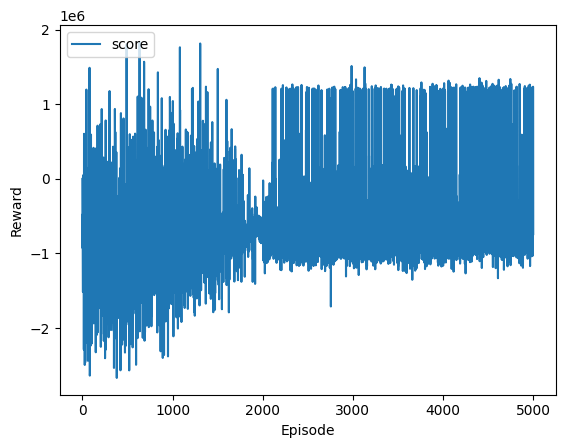

In [12]:
# TRAINING
q_table, bins = Qtable(6, 3)

Q_learning(q_table, bins, lr = 0.1, gamma = 0.9, episodes = 5*10**3, epsilon = 0.2)

### 참고) 차익 계산


In [13]:
# 차익 계산 코드
data = [{'action': 1, 'price': 38229000, 'time': '2023-05-03T17:21:00+00:00'}, {'action': 2, 'price': 38372000, 'time': '2023-05-03T17:24:00+00:00'}, {'action': 1, 'price': 38350000, 'time': '2023-05-03T17:27:00+00:00'}, {'action': 2, 'price': 38391000, 'time': '2023-05-03T17:28:00+00:00'}, {'action': 1, 'price': 38310000, 'time': '2023-05-03T17:34:00+00:00'}, {'action': 2, 'price': 38341000, 'time': '2023-05-03T17:36:00+00:00'}, {'action': 1, 'price': 38495000, 'time': '2023-05-03T17:44:00+00:00'}, {'action': 2, 'price': 38385000, 'time': '2023-05-03T17:46:00+00:00'}, {'action': 1, 'price': 38400000, 'time': '2023-05-03T17:52:00+00:00'}, {'action': 2, 'price': 38282000, 'time': '2023-05-03T17:56:00+00:00'}, {'action': 1, 'price': 38399000, 'time': '2023-05-03T18:23:00+00:00'}, {'action': 2, 'price': 38370000, 'time': '2023-05-03T18:24:00+00:00'}, {'action': 1, 'price': 38359000, 'time': '2023-05-03T18:25:00+00:00'}, {'action': 2, 'price': 38177000, 'time': '2023-05-03T18:42:00+00:00'}, {'action': 1, 'price': 38164000, 'time': '2023-05-03T18:57:00+00:00'}, {'action': 2, 'price': 38201000, 'time': '2023-05-03T19:04:00+00:00'}, {'action': 1, 'price': 38022000, 'time': '2023-05-03T19:10:00+00:00'}, {'action': 2, 'price': 38084000, 'time': '2023-05-03T19:14:00+00:00'}, {'action': 1, 'price': 38142000, 'time': '2023-05-03T19:38:00+00:00'}, {'action': 2, 'price': 38096000, 'time': '2023-05-03T19:41:00+00:00'}, {'action': 1, 'price': 38132000, 'time': '2023-05-03T19:46:00+00:00'}, {'action': 2, 'price': 38132000, 'time': '2023-05-03T19:47:00+00:00'}, {'action': 1, 'price': 38137000, 'time': '2023-05-03T19:57:00+00:00'}, {'action': 2, 'price': 38134000, 'time': '2023-05-03T20:03:00+00:00'}, {'action': 1, 'price': 38269000, 'time': '2023-05-03T20:22:00+00:00'}, {'action': 2, 'price': 38248000, 'time': '2023-05-03T20:27:00+00:00'}, {'action': 1, 'price': 38243000, 'time': '2023-05-03T20:29:00+00:00'}, {'action': 2, 'price': 38179000, 'time': '2023-05-03T20:35:00+00:00'}, {'action': 1, 'price': 38132000, 'time': '2023-05-03T20:42:00+00:00'}, {'action': 2, 'price': 38150000, 'time': '2023-05-03T20:47:00+00:00'}, {'action': 1, 'price': 38150000, 'time': '2023-05-03T20:48:00+00:00'}, {'action': 2, 'price': 38333000, 'time': '2023-05-03T20:57:00+00:00'}, {'action': 1, 'price': 38356000, 'time': '2023-05-03T21:03:00+00:00'}, {'action': 2, 'price': 38751000, 'time': '2023-05-03T21:34:00+00:00'}, {'action': 1, 'price': 38788000, 'time': '2023-05-03T21:38:00+00:00'}, {'action': 2, 'price': 38769000, 'time': '2023-05-03T21:39:00+00:00'}, {'action': 1, 'price': 38777000, 'time': '2023-05-03T21:51:00+00:00'}, {'action': 2, 'price': 38820000, 'time': '2023-05-03T21:52:00+00:00'}, {'action': 1, 'price': 38980000, 'time': '2023-05-03T22:22:00+00:00'}, {'action': 2, 'price': 38960000, 'time': '2023-05-03T22:23:00+00:00'}, {'action': 1, 'price': 38972000, 'time': '2023-05-03T22:37:00+00:00'}, {'action': 2, 'price': 38994000, 'time': '2023-05-03T22:41:00+00:00'}, {'action': 1, 'price': 38857000, 'time': '2023-05-03T22:55:00+00:00'}, {'action': 2, 'price': 38890000, 'time': '2023-05-03T22:56:00+00:00'}, {'action': 1, 'price': 38862000, 'time': '2023-05-03T22:59:00+00:00'}, {'action': 2, 'price': 38845000, 'time': '2023-05-03T23:00:00+00:00'}, {'action': 1, 'price': 38777000, 'time': '2023-05-03T23:10:00+00:00'}, {'action': 2, 'price': 38798000, 'time': '2023-05-03T23:11:00+00:00'}, {'action': 1, 'price': 38851000, 'time': '2023-05-03T23:14:00+00:00'}, {'action': 2, 'price': 38850000, 'time': '2023-05-03T23:16:00+00:00'}, {'action': 1, 'price': 38855000, 'time': '2023-05-03T23:24:00+00:00'}, {'action': 2, 'price': 38856000, 'time': '2023-05-03T23:27:00+00:00'}, {'action': 1, 'price': 38793000, 'time': '2023-05-03T23:30:00+00:00'}, {'action': 2, 'price': 38719000, 'time': '2023-05-03T23:33:00+00:00'}, {'action': 1, 'price': 38732000, 'time': '2023-05-03T23:40:00+00:00'}, {'action': 2, 'price': 38682000, 'time': '2023-05-03T23:45:00+00:00'}]

last_profit = 0
buy_price = 0

for row in data:
    if row['action'] == 1:  # 매수
        buy_price = row['price']
    elif row['action'] == 2 and buy_price != 0:  # 매도
        sell_price = row['price']
        profit = sell_price - buy_price
        last_profit = profit
        buy_price = 0

print("차익:", last_profit)

차익: 19000.0


# 50개 랜덤 테스트

## 업비트에서 랜덤한 50개 날짜 400데이터셋

In [31]:
# upbit 에서 랜덤한 50개의 400데이터셋을 가지고 옵니다.
# 2017 10 01 ~ 2023 05 31 사이의 랜덤 선택
import requests
import random
import pandas as pd

def get_random_candle_data():
    url = "https://crix-api-endpoint.upbit.com/v1/crix/candles/minutes/1"
    code = "CRIX.UPBIT.KRW-BTC"
    count = 400  # 각 데이터셋의 개수
    start_date = "2017-10-01"
    end_date = "2023-05-31"
    data = []  # 가져온 데이터를 저장할 리스트
    
    # 2017년 10월 1일부터 2023년 5월 31일까지의 시간 범위 생성
    time_range = pd.date_range(start=start_date, end=end_date, freq='1min')
    
    # 랜덤으로 50개의 데이터셋 선택
    selected_times = random.sample(list(time_range), 50)
    
    for time in selected_times:
        # 선택된 시간을 query param 'to'에 지정하여 데이터 가져오기
        params = {
            "code": code,
            "count": count,
            "to": time.strftime("%Y-%m-%dT%H:%M:%SZ")
        }
        
        response = requests.get(url, params=params)
        
        if response.status_code == 200:
            candles = response.json()
            data.append(candles)
        else:
            print("데이터를 가져오는데 실패하였습니다.")
            break
    
    return data

# 데이터 요청 및 출력
candle_data = get_random_candle_data()
print(candle_data[1], candle_data[2])

[{'candleDateTime': '2018-07-01T23:58:00+00:00', 'candleDateTimeKst': '2018-07-02T08:58:00+09:00', 'openingPrice': 7101000.0, 'highPrice': 7112000.0, 'lowPrice': 7101000.0, 'tradePrice': 7102000.0, 'candleAccTradeVolume': 3.79574783, 'candleAccTradePrice': 26979541.48757, 'timestamp': 1530489544605, 'code': 'CRIX.UPBIT.KRW-BTC', 'unit': 1}, {'candleDateTime': '2018-07-01T23:57:00+00:00', 'candleDateTimeKst': '2018-07-02T08:57:00+09:00', 'openingPrice': 7106000.0, 'highPrice': 7107000.0, 'lowPrice': 7101000.0, 'tradePrice': 7101000.0, 'candleAccTradeVolume': 1.28402775, 'candleAccTradePrice': 9123010.78407, 'timestamp': 1530489484212, 'code': 'CRIX.UPBIT.KRW-BTC', 'unit': 1}, {'candleDateTime': '2018-07-01T23:56:00+00:00', 'candleDateTimeKst': '2018-07-02T08:56:00+09:00', 'openingPrice': 7101000.0, 'highPrice': 7106000.0, 'lowPrice': 7101000.0, 'tradePrice': 7106000.0, 'candleAccTradeVolume': 0.77022505, 'candleAccTradePrice': 5469882.39179, 'timestamp': 1530489417366, 'code': 'CRIX.UPB

## 학습된 모델 함수 정의

In [32]:
def Q_testing(q_table, bins, train_data, gamma = 0.95, lr = 0.1, timestep = 5000, epsilon = 0.001):
    rewards = 0
    data = {'score' : [0]}
    
    first_data = []

    # 1번 선회
    for episode in range(1):
        score = 0

        # 0 : 중립, 1 : 매수, 2 : 매도
        last_diff_action = 0
        last_buy_stock = {}
        done = False # 미사용

        # 초기 값 설정
        current_stock = train_data[4]
        next_stock = train_data[5]
        current_state = Discrete([train_data[1]['tradePrice'] - train_data[0]['tradePrice'],
                                  train_data[2]['tradePrice'] - train_data[1]['tradePrice'],
                                  train_data[3]['tradePrice'] - train_data[2]['tradePrice'],
                                  train_data[4]['tradePrice'] - train_data[3]['tradePrice'],
                                  next_stock['tradePrice'] - current_stock['tradePrice'],
                                  next_stock['candleAccTradeVolume']]
                                 ,bins)
        
        # 학습 데이터를 처음부터 끝까지 학습
        for index, next_stock in enumerate(train_data):
          
          if index < 5:
            continue

          if not done:
              # 액션 선택
              # 엡실론-그리디 정책에 따라, 어느 정도 확률로 무작위 액션을 시행
              if np.random.uniform(0,1) < epsilon:
                  # 매수한 상태 (중립 0, 매도 2만 가능)
                  if last_diff_action == 1:
                    action = random.choice([0, 2])
                  # 매도한 상태 (중립 0, 매수 1만 가능)
                  elif last_diff_action == 2:
                    action = random.choice([0, 1])
                  # 매수 매도 기록 없는 경우 (중립 0, 매수 1 가능)
                  else:
                    action = random.choice([0, 1])             
              else:
                  # 또는 최적의 Q-value에 따른 액션을 선택
                  action = np.argmax(q_table[current_state])

                  # 만약 추가 매매가 최적의 액션일 경우 액션을 중립으로 변경
                  if last_diff_action == 1 and last_diff_action == action:
                    action = 0
                  elif last_diff_action == 2 and last_diff_action == action:
                    action = 0
                  elif last_diff_action == 0 and action == 2:
                    action = 0
              
              # 현재 인덱스에 해당하는 주가 데이터를 보고 해당 선택에 대한 리워드를 지급

              # 매수 행동
              if action == 1:
                last_diff_action = 1
                last_buy_stock = next_stock
              # 매도 행동 (차익)
              elif action == 2:
                last_diff_action = 2
                last_buy_stock = {}
              # 중립 행동
              else:
                None

              if action != 0:
                first_data_tmp = {'action' : action, 'price' : current_stock['tradePrice'], 'time' : current_stock['candleDateTime']}
                first_data.append(first_data_tmp)

              # 상태 설정
              next_state = Discrete([train_data[index-5]['tradePrice'] - train_data[index-6]['tradePrice'],
                                  train_data[index-3]['tradePrice'] - train_data[index-4]['tradePrice'],
                                  train_data[index-2]['tradePrice'] - train_data[index-3]['tradePrice'],
                                  train_data[index-1]['tradePrice'] - train_data[index-2]['tradePrice'],
                                  next_stock['tradePrice'] - current_stock['tradePrice'],
                                  next_stock['candleAccTradeVolume']]
                                 ,bins)

              current_state = next_state
              current_stock = next_stock

        return first_data

In [33]:
def get_score(data):
  last_profit = 0
  buy_price = 0
  
  for row in data:
    if row['action'] == 1:  # 매수
      buy_price = row['price']
    elif row['action'] == 2 and buy_price != 0:  # 매도
      sell_price = row['price']
      profit = sell_price - buy_price
      last_profit = profit
      buy_price = 0
  return last_profit
  

## 반복하여 각 차익 계산

In [52]:
result = []

for data in candle_data:
  score_history = Q_testing(q_table, bins, data,lr = 0.1, gamma = 0.9, epsilon = 0.001)
  score = get_score(score_history)
  result.append((score, data[0]['candleDateTime']))

## bioxplot

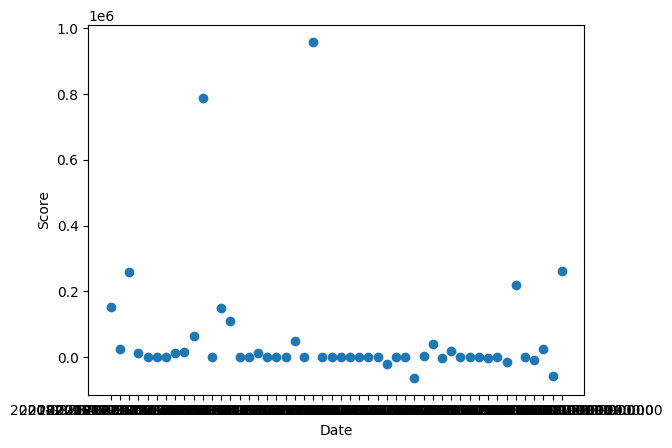

In [60]:
# 데이터 시각화
scores = [r[0] for r in result]
dates = [r[1] for r in result]

plt.scatter(dates, scores)
plt.ylabel('Score')
plt.xlabel('Date')
plt.show()

## bioxplot

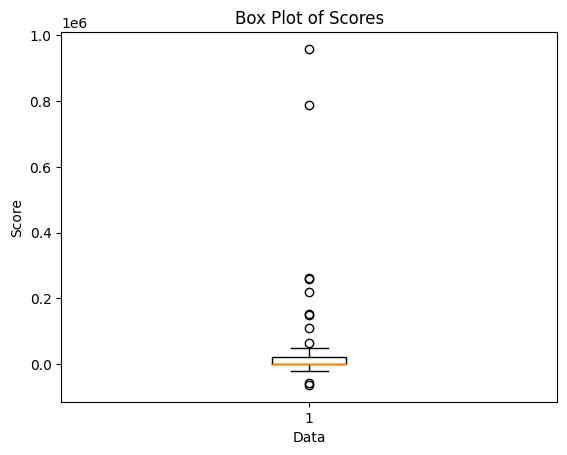

In [59]:
# 데이터 시각화
scores = [r[0] for r in result]

plt.boxplot(scores)
plt.ylabel('Score')
plt.xlabel('Data')
plt.title('Box Plot of Scores')
plt.show()

In [65]:
import random
import pandas as pd
import numpy as np

mean_score = np.mean(scores)
std_score = np.std(scores)
min_score = np.min(scores)
max_score = np.max(scores)

print("Mean Score:", mean_score)
print("Standard Deviation:", std_score)
print("Minimum Score:", min_score)
print("Maximum Score:", max_score)

Mean Score: 60360.0
Standard Deviation: 179831.44997469158
Minimum Score: -63000.0
Maximum Score: 959000.0


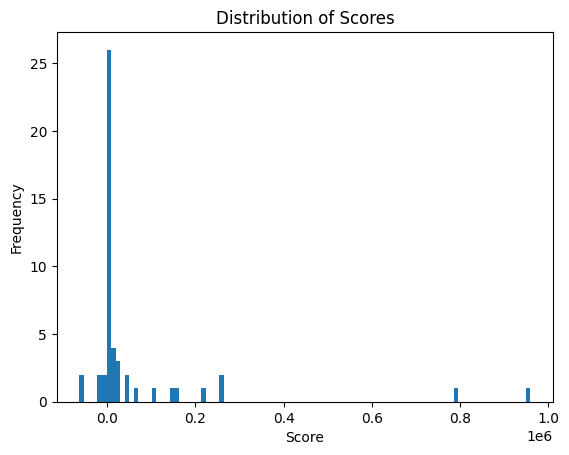

In [72]:
# 데이터 처리
scores = [r[0] for r in result]

# 데이터 분포 시각화
plt.hist(scores, bins=100)  # 히스토그램 생성
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Distribution of Scores')
plt.show()